# Training EfficientDet for Early Fire Detection on FLAME Aerial Dataset

## Introduction

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies
* Download custom dataset
* Write training configuation yaml file
* Train detection model
* Use trained PyTorch RetinaNet object detection for inference on test images


## Install Pytorch Retinanet and Dependencies

In [1]:
# !pip install -Uqq pytorch-lightning==1.0.0 omegaconf
# !pip install -Uqq git+https://github.com/albumentations-team/albumentations
# !git clone https://github.com/benihime91/pytorch_retinanet.git

In [2]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Prepare Pytorch Retinanet Object Detection Training Data

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [3]:
#Set up paths

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/train/"
VALID_IMAGE_PATH = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/valid/"
TEST_IMAGE_PATH  = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/train/"
VALID_ANNOT_PATH = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/valid/"
TEST_ANNOT_PATH  = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/test/"

In [4]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import sys
sys.path.append("/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/pytorch_retinanet/")

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## Generate csv file from XML Annotations:

In [5]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **CSV Files are as follows :**

In [6]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,./flame_annotated_v6i/train/image_838_jpg.rf.8fcde3291c2da02245263f1b93d92073.jpg,640,640,fire,289.0,222.0,341,324,1
1,./flame_annotated_v6i/train/image_838_jpg.rf.8fcde3291c2da02245263f1b93d92073.jpg,640,640,fire,603.0,116.0,628,191,1
2,./flame_annotated_v6i/train/image_838_jpg.rf.8fcde3291c2da02245263f1b93d92073.jpg,640,640,fire,538.0,340.0,588,417,1
3,./flame_annotated_v6i/train/image_838_jpg.rf.8fcde3291c2da02245263f1b93d92073.jpg,640,640,fire,598.0,417.0,640,443,1
4,./flame_annotated_v6i/train/image_791_jpg.rf.539054fccf92cd239a203511ca49d9c7.jpg,640,640,fire,69.0,66.0,97,144,1


In [7]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,./flame_annotated_v6i/valid/image_89_jpg.rf.3a0cd9d449fcad3479e9a9363efcc17c.jpg,640,640,fire,349.0,110.0,394,183,1
1,./flame_annotated_v6i/valid/image_89_jpg.rf.3a0cd9d449fcad3479e9a9363efcc17c.jpg,640,640,fire,594.0,115.0,615,155,1
2,./flame_annotated_v6i/valid/image_637_jpg.rf.260943e3d9998cab120a8f452849c1da.jpg,640,640,fire,92.0,116.0,139,234,1
3,./flame_annotated_v6i/valid/image_637_jpg.rf.260943e3d9998cab120a8f452849c1da.jpg,640,640,fire,364.0,132.0,414,251,1
4,./flame_annotated_v6i/valid/image_637_jpg.rf.260943e3d9998cab120a8f452849c1da.jpg,640,640,fire,479.0,360.0,544,460,1


In [8]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,./flame_annotated_v6i/test/image_168_jpg.rf.034a0a62657ff918227c94e06fc51251.jpg,640,640,fire,286.0,121.0,350,194,1
1,./flame_annotated_v6i/test/image_168_jpg.rf.034a0a62657ff918227c94e06fc51251.jpg,640,640,fire,573.0,100.0,640,209,1
2,./flame_annotated_v6i/test/image_168_jpg.rf.034a0a62657ff918227c94e06fc51251.jpg,640,640,fire,526.0,128.0,546,159,1
3,./flame_annotated_v6i/test/image_242_jpg.rf.10c90a5305aa76bf6a3698405273b13a.jpg,640,640,fire,270.0,111.0,315,203,1
4,./flame_annotated_v6i/test/image_242_jpg.rf.10c90a5305aa76bf6a3698405273b13a.jpg,640,640,fire,492.0,135.0,506,173,1


In [9]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/train_data.csv"
VALID_CSV = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/valid_data.csv"
TEST_CSV  = "/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/flame_annotated_v6i/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [10]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

## View Images from the Dataset:

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

Let's now generate the Label Map which is used for visualization:

In [11]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'fire']

Plot images with Bounding boxes over them:

In [12]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

Image from Train Data:

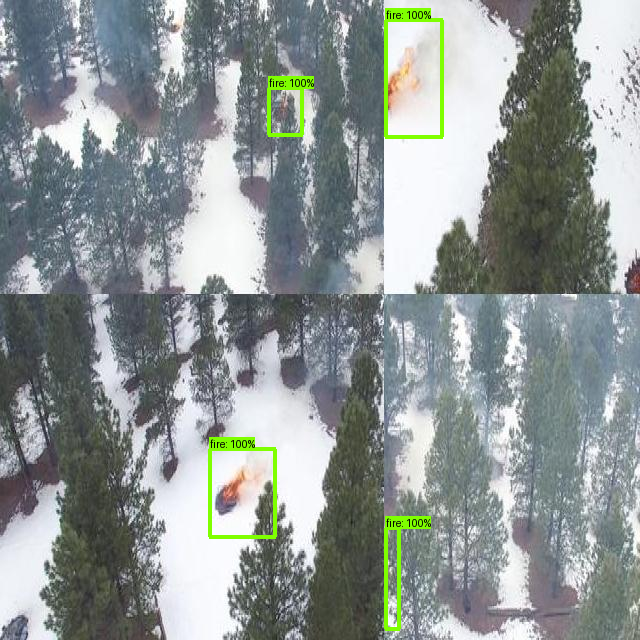

In [13]:
image = load_image_from_data(train_df, index=10)
image

Image from Validation Data:

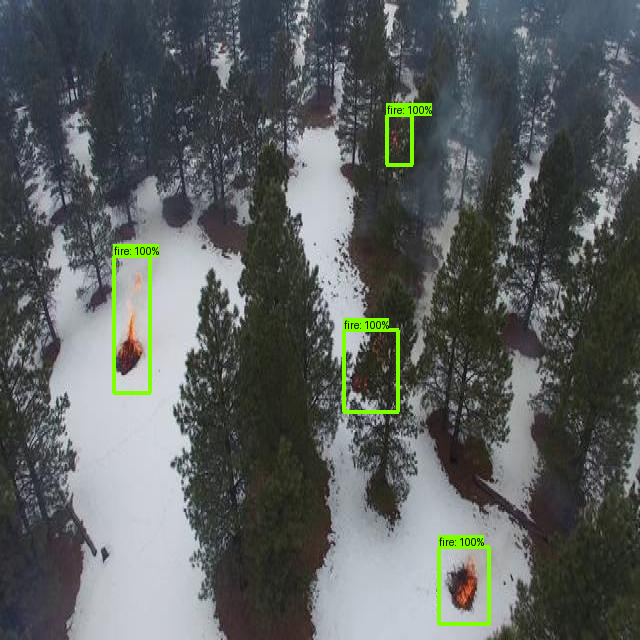

In [14]:
image = load_image_from_data(valid_df, index=10)
image

Image from Test Data:

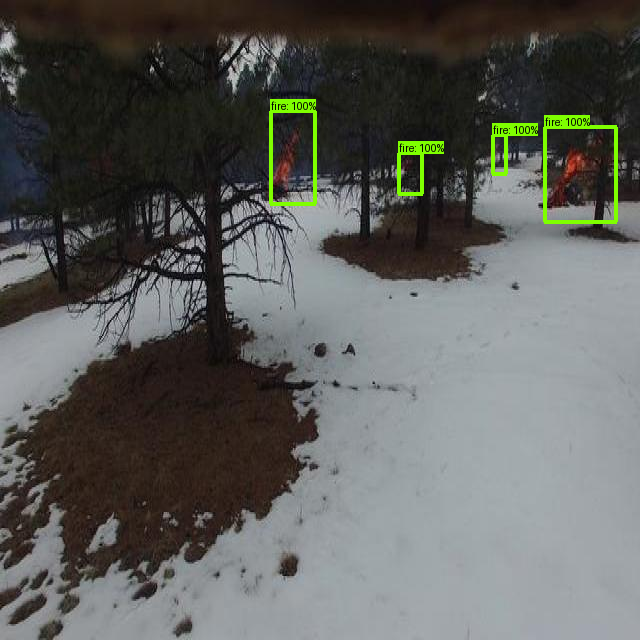

In [15]:
image = load_image_from_data(test_df, index=5)
image

## Configure Custom PyTorch RetianNet Object Detection Training Configuration:

In [16]:
NUM_TRAIN_EPOCHS = 20


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 1
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP) - 1
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD",
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR",
    "params"     : {"T_max": NUM_TRAIN_EPOCHS},
    "monitor"    : None,
    "interval"   : "epoch",
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 1
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: ./flame_annotated_v6i/train_data.csv
  valid_paths: ./flame_annotated_v6i/valid_data.csv
  test_paths: ./flame_annotated_v6i/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 20
  monitor: null
  interval: epoch
  frequency: 1



Instantiate Lightning-Module and Lightning-Trainer

In [17]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from model import RetinaNetModel

# seed so that results are reproducible
pl.seed_everything(123)

123

## Load in the Lightning-Trainer:

In [18]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE:
# For a list of whole trainer specific arguments see :
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Load in the Lighning-Module using the hparams file modified above & Start Train:

In [19]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 1


In [20]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Epoch 19: 100%|██████████| 465/465 [00:20<00:00, 23.12it/s, loss=0.441, v_num=0, classification_loss=0.652, regression_loss=0.237, val_loss=0.376]  


1

Evaluating the trained-model using COCO-API Metrics:

In [23]:
trainer.test(litModel)

creating index...
index created!
Testing:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s]Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 |

[{'AP': 0.26104038975326105}]

## Export the model weights:

In [26]:
import torch
PATH = f"/home/calvinzhou/py-workspace/a2d2/RetinaNet-data/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

Load PyTorch Model from the trained Lightning-Module weights:

In [27]:
import logging
logger = logging.getLogger("lightning")

In [28]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 1


## Run Inference on Test Images with Custom PyTorch Object Detector

In [29]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on
        the given image.
        Keys of the dictionary:
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])

    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions

    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.

    Params
    ------
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

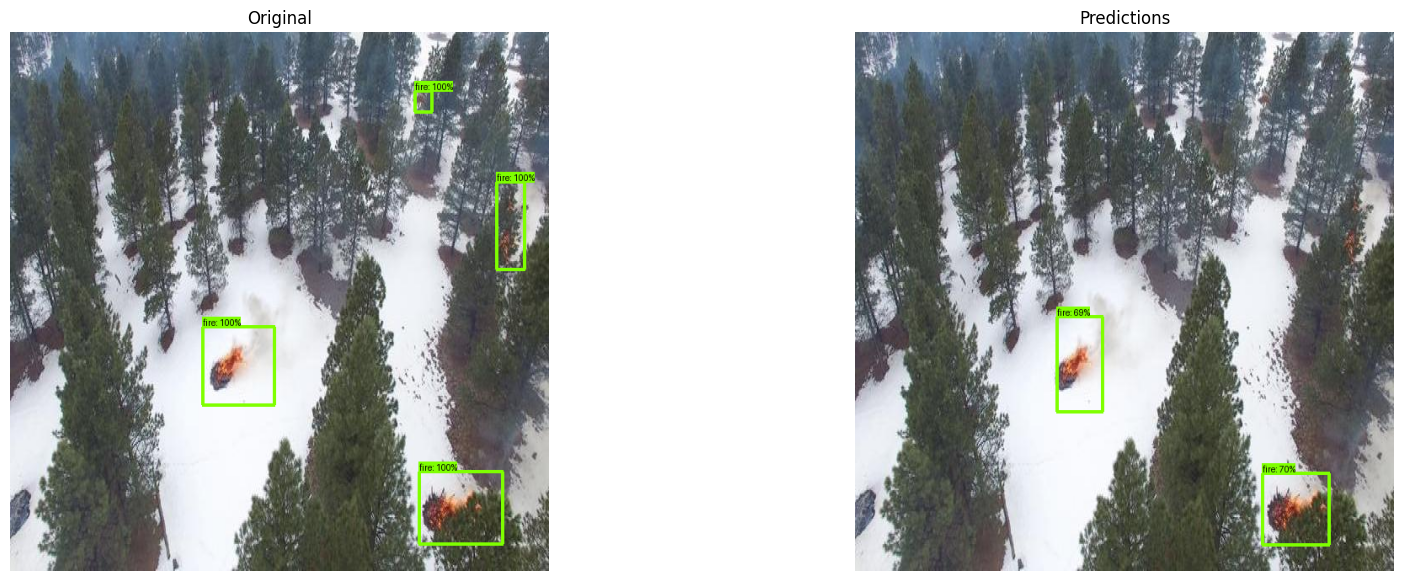

In [30]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

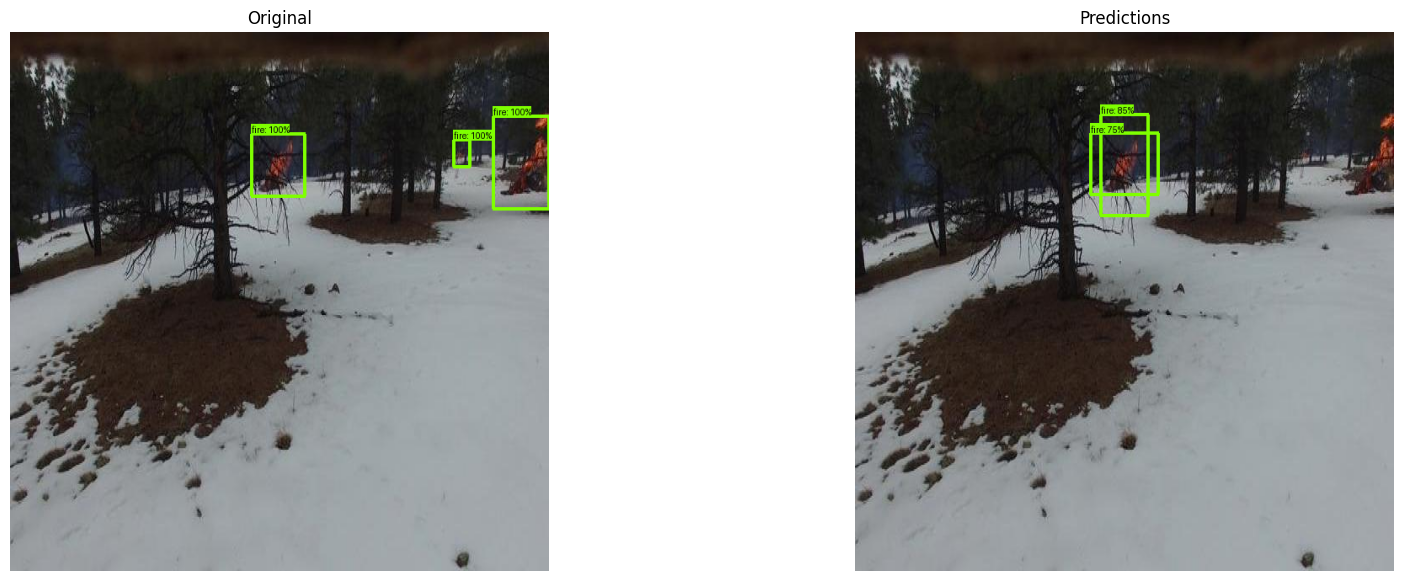

In [31]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");